In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('bikesharing_clean.csv')
data.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   mnth        731 non-null    int64  
 2   holiday     731 non-null    int64  
 3   weekday     731 non-null    int64  
 4   workingday  731 non-null    int64  
 5   weathersit  731 non-null    int64  
 6   temp        731 non-null    float64
 7   atemp       731 non-null    float64
 8   hum         731 non-null    float64
 9   windspeed   731 non-null    float64
 10  cnt         731 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 62.9 KB


#### Ridge

In [4]:
y = data[['cnt']]
X = data.drop('cnt', axis=1)

In [5]:
from sklearn.linear_model import Ridge

In [6]:
num_iter = 5000

alph_arr_log = np.logspace(0, 5, num_iter)

coeff_mat = np.zeros(shape=(10,num_iter),dtype=float)

for i in range(len(alph_arr_log)):
    r_m = Ridge(alpha=alph_arr_log[i], fit_intercept=True)
    r_m.fit(X, y)
    coeff_mat[:, i] = r_m.coef_

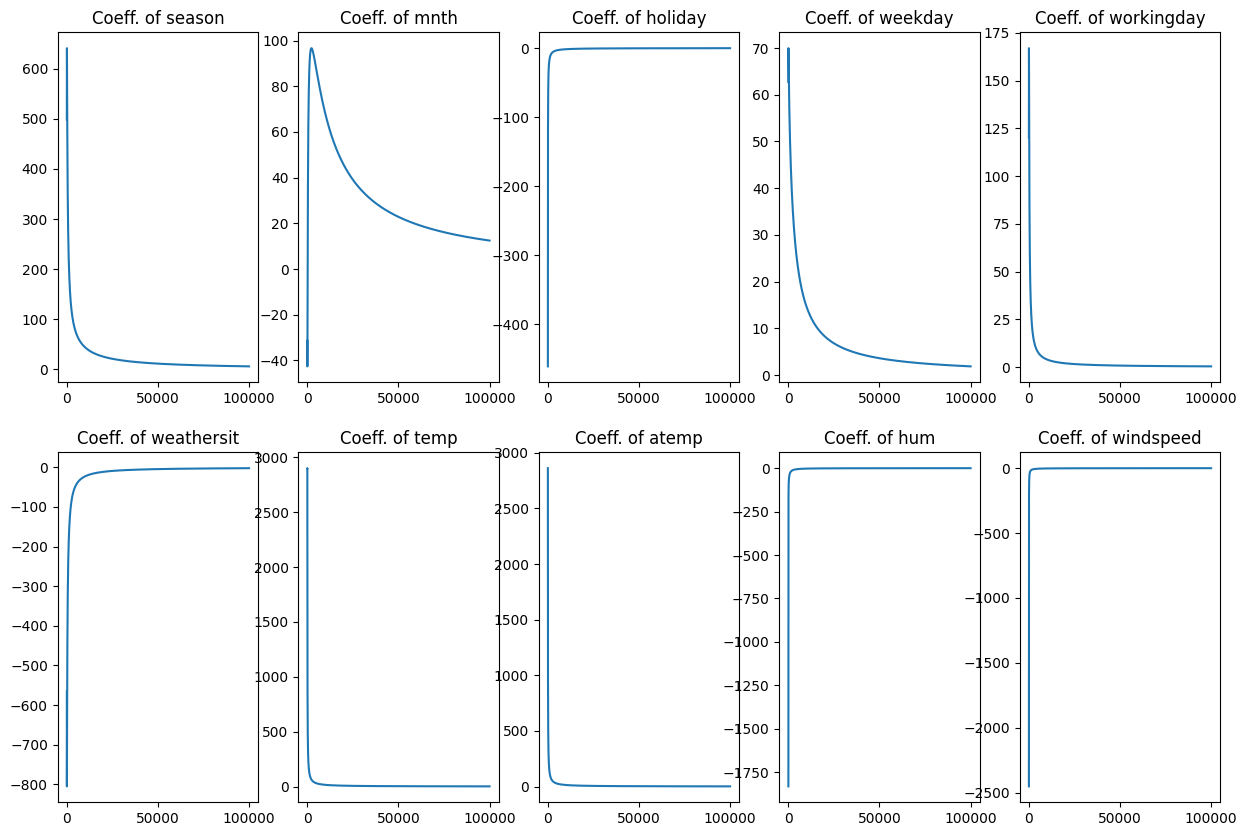

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,10))

ax_flat = ax.flatten()

for i in range(10):
    ax_flat[i].plot(alph_arr_log,coeff_mat[i,:])
    ax_flat[i].set_title(f'Coeff. of {X.columns[i]}')

#### From plots above we see most coefficients start to stabilize around 50000 and coefficient of `mnth` has changed sign and is starting to stabilize. So from the ridge trace we take `alpha=50000`.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
alpha = 50000

ridge_final = Ridge(alpha=alpha, fit_intercept=True)

ridge_final.fit(X_train, y_train)

Ridge(alpha=50000)

In [11]:
y_pred = ridge_final.predict(X_test)
r2_score(y_test, y_pred)

0.021861508277231767

#### We see above the $R^2$ score is poor. This is because $\alpha$ value chosen is too large and coefficients have shrunk too much and all predictions are close to the intercept. Looking at ridge trace to find the right value is not the approach because we have a very large range of $\alpha$ values to look at. We try cross validation to find the best $\alpha$.

#### Ridge regression using cross-validation

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [13]:
alpha_arr = np.linspace(0, 500, 10000) 
param_grid = {'alpha':alpha_arr} 
ridge_rand_cv = RandomizedSearchCV(estimator=Ridge(fit_intercept=True), param_distributions=param_grid, n_iter=2000, random_state=42, cv=5)

In [14]:
ridge_rand_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=2000,
                   param_distributions={'alpha': array([0.00000000e+00, 5.00050005e-02, 1.00010001e-01, ...,
       4.99899990e+02, 4.99949995e+02, 5.00000000e+02], shape=(10000,))},
                   random_state=42)

In [15]:
ridge_rand_cv.best_params_

{'alpha': np.float64(0.6000600060006)}

In [16]:
y_pred_cv = ridge_rand_cv.predict(X_test)

In [17]:
r2_score(y_test, y_pred_cv)

0.4932209751419995

In [18]:
ridge_rand_cv.best_estimator_.coef_

array([  445.57313675,   -17.89964758,  -457.17723415,    63.83487607,
         102.43556106,  -347.37440523,  3322.33947609,  2675.98854583,
       -2557.83886418, -3140.06929573])

#### Lasso

In [19]:
from sklearn.linear_model import Lasso

In [20]:
alpha_arr = np.linspace(0, 500, 10000) 
param_grid = {'alpha':alpha_arr} 
lasso_rand_cv = RandomizedSearchCV(estimator=Lasso(fit_intercept=True), param_distributions=param_grid, n_iter=2000, random_state=42, cv=5)

In [21]:
lasso_rand_cv.fit(X_train, y_train)

/home/harry/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.745e+05, tolerance: 1.684e+05
  model = cd_fast.enet_coordinate_descent(
/home/harry/.local/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/harry/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/harry/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=2000,
                   param_distributions={'alpha': array([0.00000000e+00, 5.00050005e-02, 1.00010001e-01, ...,
       4.99899990e+02, 4.99949995e+02, 5.00000000e+02], shape=(10000,))},
                   random_state=42)

In [22]:
lasso_rand_cv.best_params_

{'alpha': np.float64(0.85008500850085)}

In [23]:
lasso_rand_cv.best_estimator_.coef_

array([  437.18682795,   -16.65389542,  -451.02160997,    62.37753158,
          92.40358504,  -288.14783389,  4260.51085902,  1724.5494448 ,
       -2858.32156103, -3739.35291211])

In [24]:
y_pred_lasso = lasso_rand_cv.predict(X_test)
r2_score(y_test, y_pred_lasso)

0.48313797936779435

#### Plot of test scores vs alpha for Lasso and Ridge

In [25]:
ridge_cv_mean = np.array(ridge_rand_cv.cv_results_['mean_test_score'])
ridge_alpha = np.array(ridge_rand_cv.cv_results_['param_alpha'])

lasso_cv_mean = np.array(lasso_rand_cv.cv_results_['mean_test_score'])
lasso_alpha = np.array(lasso_rand_cv.cv_results_['param_alpha'])

In [26]:
np.allclose(ridge_alpha, lasso_alpha)

True

In [27]:
idx_ridge = np.argsort(ridge_alpha)
ridge_alpha = ridge_alpha[idx_ridge]
ridge_cv_mean = ridge_cv_mean[idx_ridge]

idx_lasso = np.argsort(lasso_alpha)
lasso_alpha = lasso_alpha[idx_lasso]
lasso_cv_mean = lasso_cv_mean[idx_lasso]

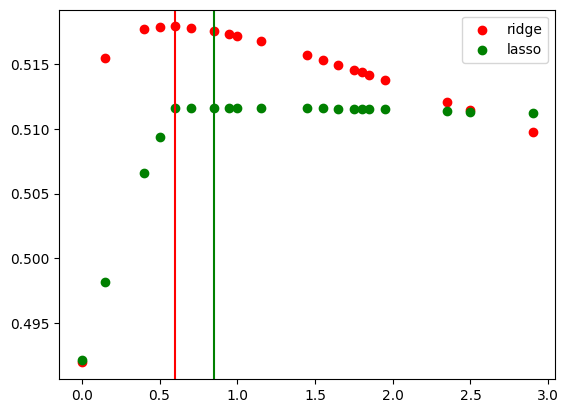

In [28]:
fig, ax = plt.subplots()

ax.scatter(ridge_alpha[:20], ridge_cv_mean[:20], color = 'r', label ='ridge')
ax.scatter(lasso_alpha[:20], lasso_cv_mean[:20], color ='g', label ='lasso')
ax.axvline(ridge_alpha[np.argmax(ridge_cv_mean)],color='r')
ax.axvline(lasso_alpha[np.argmax(lasso_cv_mean)],color='g')
plt.legend()

plt.show()

#### Feature selection using Lasso
#### From PCA we see that it selected 5 features. So let us try to do feature selection with Lasso. We saw above with cv it did not shrink any of the coefficients down to 0.

#### Let us first see what is the first value of alpha at which one of the coefficients goes to 0. We start at 5.6 which was obtained above using GridSearchCV. In PCA we ended up with 5 principal components. So let's see if we can select 5 features using Lasso while ensuring $R^2$ does not fall drastically.

In [29]:
alpha = 5.6
R2 = 0.5
dropped_cols = []
num_dropped = 0
total_cols = X.columns

lasso = Lasso(alpha= alpha, fit_intercept=True)
lasso.fit(X_train, y_train)

while True:
    lasso = Lasso(alpha= alpha, fit_intercept=True)
    lasso.fit(X_train, y_train)
    if (sum(lasso.coef_==0)==num_dropped+1) & (num_dropped <= X.shape[1]) :
        if sum(lasso.coef_==0)==1:
            print(f'First feature removed is: {X.columns[lasso.coef_==0][0]} and corresponding alpha value is: {alpha}')
            print()
        y_pred = lasso.predict(X_test)
        if r2_score(y_test, y_pred) <=0.48:
            break
        R2 = r2_score(y_test, y_pred)
        
        col2add = [a for a in X.columns[lasso.coef_==0] if a not in dropped_cols]
        dropped_cols.append(col2add[-1])
        num_dropped += 1
        print(list(dropped_cols))
        print(R2)
        print()

    alpha += 0.2

print(f'Dropped columns are:{list(dropped_cols)}')
print(f'R2 score: {R2}')
print(f'alpha:{alpha-0.2}')

First feature removed is: atemp and corresponding alpha value is: 10.799999999999992

['atemp']
0.5002526177983047

['atemp', 'holiday']
0.5013126961355768

['atemp', 'holiday', 'windspeed']
0.5009236594192761

['atemp', 'holiday', 'windspeed', 'hum']
0.49993437490390746

['atemp', 'holiday', 'windspeed', 'hum', 'mnth']
0.4947757556280151

['atemp', 'holiday', 'windspeed', 'hum', 'mnth', 'workingday']
0.4907624755091803

Dropped columns are:['atemp', 'holiday', 'windspeed', 'hum', 'mnth', 'workingday']
R2 score: 0.4907624755091803
alpha:186.79999999999794


In [30]:
dropped_cols

['atemp', 'holiday', 'windspeed', 'hum', 'mnth', 'workingday']

In [31]:
lasso = Lasso(alpha=186.8, fit_intercept=True)
lasso.fit(X_train, y_train)
lasso.coef_

array([ 520.67948181,    0.        ,   -0.        ,    6.99352012,
          0.        , -318.43864471,    5.72108644,    0.        ,
         -0.        ,   -0.        ])

In [32]:
X.columns

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

In [33]:
rem_cols = X.columns[lasso.coef_!=0]
rem_cols

Index(['season', 'weekday', 'weathersit', 'temp'], dtype='object')

#### So we set a threshold of $R^2$ to be 0.48 and managed to remove 6 features: `atemp, holiday, windspeed, hum, mnth, workingday` for $\alpha=187.799$.

Now let's see how high does the $\alpha$ go before we manage to remove 5 features. We start with $\alpha=10.8$ at which the first feature was removed.

In [34]:
alpha = 5.6
num_dropped = 0
dropped_cols = []

while True:
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(X_train, y_train)

    alpha += 0.2

    if sum(lasso.coef_==0)==5:
        break

y_pred = lasso.predict(X_test)

print(f'alpha: {alpha-0.2}')
print(f'R2 score: {r2_score(y_test, y_pred)}')
print(f'Removed columns: {X.columns[lasso.coef_==0]}')
print(f'Remaining columns: {X.columns[lasso.coef_!=0]}')

alpha: 32.99999999999993
R2 score: 0.4947757556280151
Removed columns: Index(['mnth', 'holiday', 'atemp', 'hum', 'windspeed'], dtype='object')
Remaining columns: Index(['season', 'weekday', 'workingday', 'weathersit', 'temp'], dtype='object')


#### Elastic net

In [35]:
from sklearn.linear_model import ElasticNet

In [36]:
param_grid ={
'alpha' : np.arange(0, 188, 0.2),
'l1_ratio' : np.linspace(0,1, 50)
}

In [37]:
elastic_cv = RandomizedSearchCV(estimator=ElasticNet(fit_intercept=True), param_distributions=param_grid, n_iter=500, random_state=0)

In [38]:
elastic_cv.fit(X_train, y_train)

/home/harry/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.277e+08, tolerance: 1.671e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/harry/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.598e+08, tolerance: 1.731e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in skl

RandomizedSearchCV(estimator=ElasticNet(), n_iter=500,
                   param_distributions={'alpha': array([  0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,
         1.8,   2. ,   2.2,   2.4,   2.6,   2.8,   3. ,   3.2,   3.4,
         3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,
         5.4,   5.6,   5.8,   6. ,   6.2,   6.4,   6.6,   6.8,   7. ,
         7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,
         9. ,   9.2,   9.4,   9.6,   9.8,  10. ,  10.2,  10.4,  10.6,
        10.8,  11. ,  11.2,  11.4,  11.6,  11.8,  12. ,  12.2,  12.4,
        12.6,  12.8...
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
                   random_state=0)

In [39]:
elastic_cv.best_estimator_.coef_

array([  435.9329369 ,   -13.64198083,  -243.41916284,    62.61629814,
          95.13226039,  -412.64907845,  4946.82423603,   701.20212107,
       -2055.56714608, -2471.37755812])

In [40]:
y_pred = elastic_cv.predict(X_test)
r2_score(y_test, y_pred)

0.4961241586701334

#### ElasticNet can also do feature selection but because of presence of l2 term, coefficients go to 0 for a higher value of $\alpha$.
Let us look at values of $\alpha$ for which one of the feature exits for different values of `l1_ratio`.

When using Lasso we observed that first feature removed is: atemp and corresponding $\alpha$ value is: 10.799. So we will start with this value of $\alpha$ and l1_ratio=1 and then decrease l1_ratio to 0.05.

In [41]:
l1_rat_enet = np.arange(1, 0.05, -0.04)
alpha_enet = 10.7999*np.ones(len(l1_rat_enet))

alpha = 10.7999

for i in range(len(l1_rat_enet)):
    
    while True:
        e_net = ElasticNet(alpha=alpha, l1_ratio=l1_rat_enet[i], fit_intercept=True)
        e_net.fit(X_train, y_train)
        if any(e_net.coef_==0):
            alpha_enet[i] = alpha
            break
        alpha = alpha + 0.2

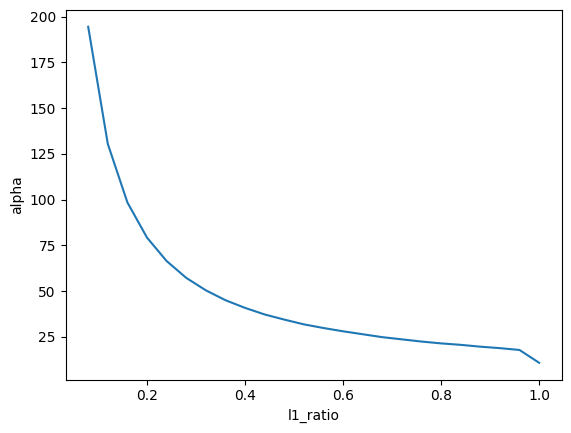

In [42]:
fig, ax = plt.subplots()

ax.plot(l1_rat_enet, alpha_enet)
ax.set_xlabel('l1_ratio')
ax.set_ylabel('alpha')

plt.show()